# Kalman Filter Parameter Optimization using Genetic Algorithm

In [62]:
# imports
import numpy as np
from deap import base, creator, tools, algorithms
from KalmanFilter import KalmanFilter
from SignalGenerator import SignalGenerator
import matplotlib.pyplot as plt
import multiprocessing
from scoop import futures

In [63]:
# Define the evaluation function
def evaluate(individual):
    q_val, r_val = individual
    F = np.array([[1]])
    H = np.array([[1]])
    Q = np.array([[q_val]])
    R = np.array([[r_val]])
    P = np.array([[0]])
    x = np.array([[0]])

    kf = KalmanFilter(F, H, Q, R, P, x)
    filtered_signal = kf.filter(noisy_signal)
    _, rmse = kf.calculate_error(true_signal, filtered_signal)
    return rmse,

# Create a synthetic signal

In [64]:
# Signal parameters
frequency = 480  # Hz
sampling_rate = 20000  # Hz
duration = 0.1  # seconds (100 ms)
amplitude = 0.1
offset = 0.1

SigGen = SignalGenerator(frequency, sampling_rate, duration, amplitude)

# Generate a clean 400 Hz sine wave
true_signal = SigGen.generate_signal('square')
true_signal = SigGen.add_offset(true_signal, offset)

# Add noise to create noisy measurement
noise_std = 0.3
noisy_signal = SigGen.add_noise(true_signal, noise_std)

# Get time vector
t= SigGen.get_time()

# Plot the original, noisy, and filtered signals

MSE: 0.022300898710507312
RMSE: 0.14933485430570892


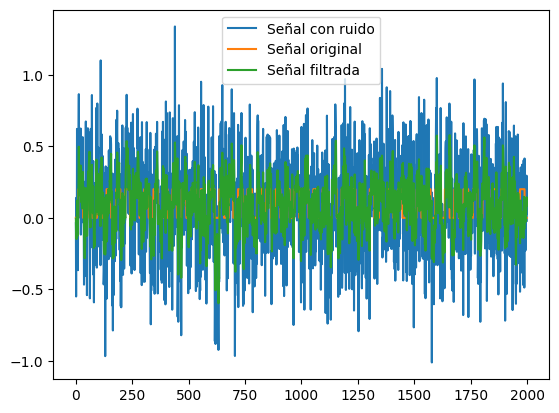

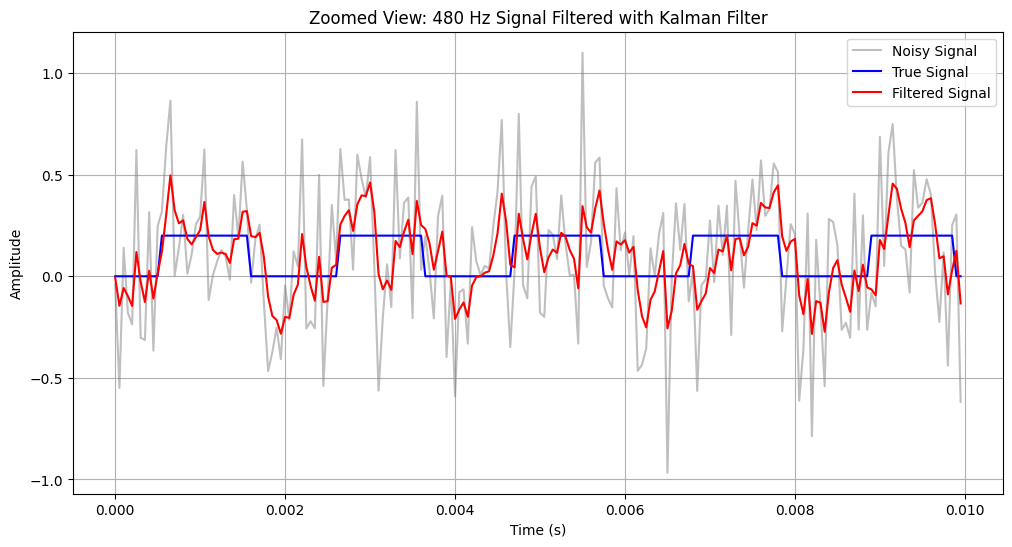

In [65]:
# Initialize Kalman filter
F = np.array([[1]])
H = np.array([[1]])
Q = np.array([[18.679136]])
R = np.array([[100]])
P = np.array([[0]])
x = np.array([[0]])

# Create and apply filter
kf = KalmanFilter(F, H, Q, R, P, x)
filtered_signal = kf.filter(noisy_signal)

# Calculate error metrics
mse, rmse = kf.calculate_error(true_signal, filtered_signal)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

# Plot results
kf.plot_results(noisy_signal, true_signal, filtered_signal)

# Zoom in to show detail
plt.figure(figsize=(12, 6))
zoom_samples = int(0.01 * sampling_rate)  # Show 10ms
plt.plot(t[:zoom_samples], noisy_signal[:zoom_samples], 'gray', alpha=0.5, label='Noisy Signal')
plt.plot(t[:zoom_samples], true_signal[:zoom_samples], 'b', label='True Signal')
plt.plot(t[:zoom_samples], filtered_signal[:zoom_samples], 'r', label='Filtered Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Zoomed View: 480 Hz Signal Filtered with Kalman Filter')
plt.legend()
plt.grid(True)
plt.show()

# Implementing the Genetic Algorithm

In [66]:
# Genetic Algorithm setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimize the RMSE
creator.create("Individual", list, fitness=creator.FitnessMin)  # Create individuals as lists
# Create the toolbox for genetic operations
toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.uniform, 1e-9, 5e3) # Random float for Q and R in the range [1e-6, 1e3]
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=2) # Each individual has two parameters: Q and R
toolbox.register("population", tools.initRepeat, list, toolbox.individual) # Create the genetic operations

toolbox.register("mate", tools.cxBlend, alpha=0.5) # Blend crossover
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2) # Gaussian mutation
toolbox.register("select", tools.selTournament, tournsize=3) # Tournament selection
toolbox.register("evaluate", evaluate) # Evaluation function to calculate RMSE for each individual
# Use elitism to preserve the best individuals
#toolbox.register("select", tools.selBest)
# Enable parallel processing
#toolbox.register("map", futures.map)
#pool = multiprocessing.Pool()
#toolbox.register("map", pool.map)

In [67]:
# Run the genetic algorithm
population = toolbox.population(n=5) # Population size
ngen = 10  # Number of generations
cxpb = 0.7  # Crossover probability
mutpb = 0.3 # Mutation probability
halloffame = tools.HallOfFame(5)  # Preserve the best individual

# Statistics to keep track of the progress
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# Run the genetic algorithm
result, logbook = algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=stats, halloffame=halloffame, verbose=True)

gen	nevals	avg     	std      	min    	max     
0  	5     	0.249192	0.0257587	0.20322	0.275722
1  	1     	0.234695	0.0271152	0.20322	0.269803
2  	5     	0.221293	0.015585 	0.20322	0.242482
3  	4     	0.20322 	0        	0.20322	0.20322 
4  	4     	0.20323 	1.91312e-05	0.20322	0.203268
5  	4     	0.20322 	1.24127e-17	0.20322	0.20322 
6  	4     	0.203217	5.38767e-06	0.203207	0.20322 
7  	3     	0.203213	9.62362e-06	0.203203	0.203228
8  	1     	0.203211	1.59521e-05	0.203203	0.203243
9  	4     	0.203203	0          	0.203203	0.203203
10 	2     	0.203203	1.45949e-07	0.203202	0.203203


In [68]:
# Close the pool
#pool.close()
#pool.join()

In [69]:
print(logbook[-1])

{'gen': 10, 'nevals': 2, 'avg': np.float64(0.2032026467149759), 'std': np.float64(1.4594890892505317e-07), 'min': np.float64(0.20320235481715807), 'max': np.float64(0.20320271968943038)}


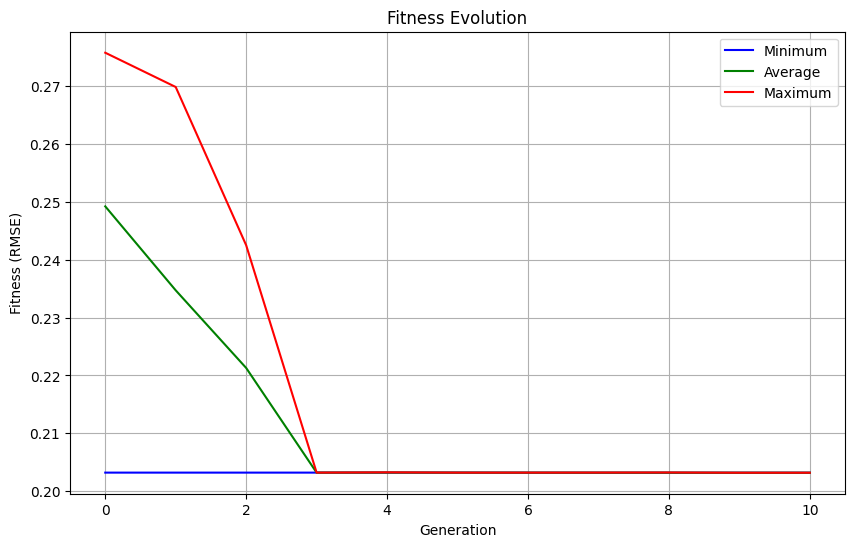

In [70]:
# Plot min, avg, max fitness over generations
plt.figure(figsize=(10, 6))
plt.plot(logbook.select("gen"), logbook.select("min"), 'b-', label='Minimum')
plt.plot(logbook.select("gen"), logbook.select("avg"), 'g-', label='Average')
plt.plot(logbook.select("gen"), logbook.select("max"), 'r-', label='Maximum')
plt.xlabel('Generation')
plt.ylabel('Fitness (RMSE)')
plt.title('Fitness Evolution')
plt.legend()
plt.grid(True)
plt.show()

# Extract the best individual

In [71]:
print(f"\n============  Hall Of Fame ==============\n")
# best_individual = tools.selBest(population, k=1)[0]
best_individual = halloffame[0]
best_q, best_r = best_individual
best_fitness = float(best_individual.fitness.values[0])
print("Best Individual:")
print(f"Individual: {best_individual}")
print(f"Best Q: {best_q}, Best R: {best_r}, Fitness: {best_fitness}")

print("\nNext Best Individuals:")
for individual in halloffame[1:]:
    q, r = individual
    fitness = float(individual.fitness.values[0])
    print(f"Q: {q}, R: {r}, Fitness: {fitness}")

print(f"\n===== Best Individual Performance =====\n")

# Create filter with optimal parameters
optimal_Q = np.array([[best_q]])
optimal_R = np.array([[best_r]])
P = np.array([[0]])
x = np.array([[0]])
optimal_kf = KalmanFilter(F, H, optimal_Q, optimal_R, P, x)
optimal_filtered = optimal_kf.filter(noisy_signal)

# Calculate improvement over original parameters
original_mse, original_rmse = kf.calculate_error(true_signal, filtered_signal)
optimal_mse, optimal_rmse = kf.calculate_error(true_signal, optimal_filtered)
improvement = ((original_rmse - optimal_rmse) / original_rmse) * 100

print(f"Original RMSE: {original_rmse:.6f}")
print(f"Optimal RMSE: {optimal_rmse:.6f}")
print(f"Improvement: {improvement:.2f}%")

print(f"\n=======================================\n")



============  Hall Of Fame ==============

Best Individual:
Individual: [1403.179475122488, 1676.8015054562966]
Best Q: 1403.179475122488, Best R: 1676.8015054562966, Fitness: 0.20320235481715807

Next Best Individuals:
Q: 1403.1794751224875, R: 1676.7862038384683, Fitness: 0.20320271968943038
Q: 1403.1794751224877, R: 1676.7862038384683, Fitness: 0.20320271968943038
Q: 1403.179475122488, R: 1676.7862038384678, Fitness: 0.20320271968943038
Q: 1403.1794751224877, R: 1676.786203838468, Fitness: 0.20320271968943038

===== Best Individual Performance =====

Original RMSE: 0.149335
Optimal RMSE: 0.203202
Improvement: -36.07%




# Test The Kalman Filter with the best parameters

MSE: 0.004354436154994278
RMSE: 0.06598815162583567


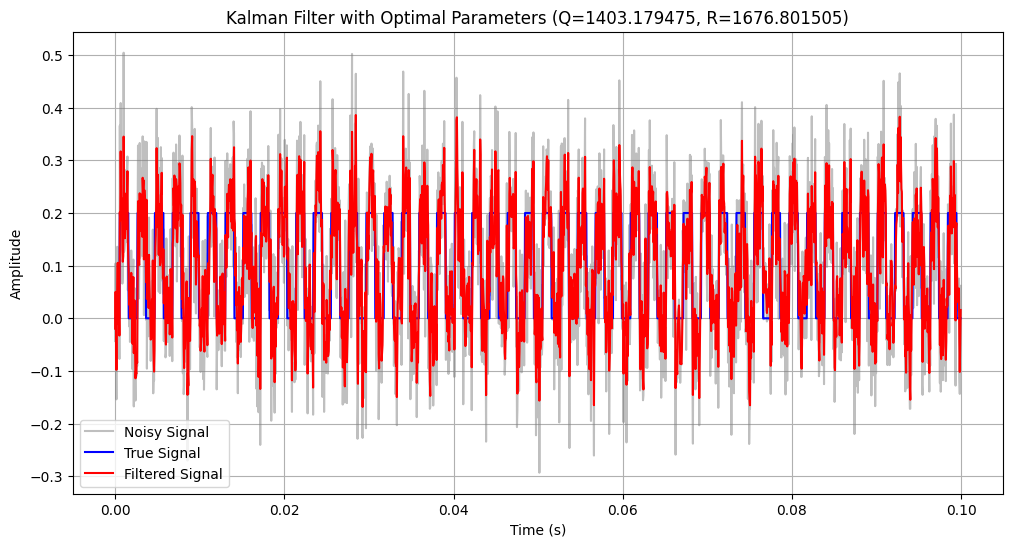

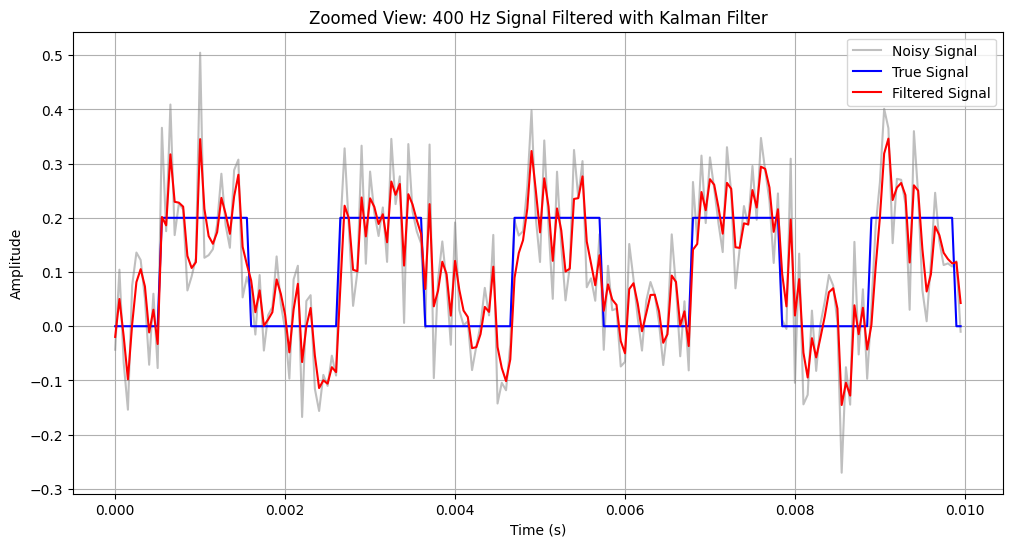

In [72]:
# Add noise to create noisy measurement
noise_std = 0.1
noisy_signal = SigGen.add_noise(true_signal, noise_std)

# Initialize Kalman filter
F = np.array([[1]])
H = np.array([[1]])
optimal_Q = np.array([[best_q]])
optimal_R = np.array([[best_r]])
P = np.array([[0]])  #
x = np.array([[0]])

# Create and apply filter
kf = KalmanFilter(F, H, optimal_Q, optimal_R, P, x)
filtered_signal = kf.filter(noisy_signal)

# Calculate error metrics
mse, rmse = kf.calculate_error(true_signal, filtered_signal)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(t, noisy_signal, 'gray', alpha=0.5, label='Noisy Signal')
plt.plot(t, true_signal, 'b', label='True Signal')
plt.plot(t, filtered_signal, 'r', label='Filtered Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title(f'Kalman Filter with Optimal Parameters (Q={best_q:.6f}, R={best_r:.6f})')
plt.legend()
plt.grid(True)

# Zoom in to show detail
plt.figure(figsize=(12, 6))
zoom_samples = int(0.01 * sampling_rate)  # Show 10ms
plt.plot(t[:zoom_samples], noisy_signal[:zoom_samples], 'gray', alpha=0.5, label='Noisy Signal')
plt.plot(t[:zoom_samples], true_signal[:zoom_samples], 'b', label='True Signal')
plt.plot(t[:zoom_samples], filtered_signal[:zoom_samples], 'r', label='Filtered Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Zoomed View: 400 Hz Signal Filtered with Kalman Filter')
plt.legend()
plt.grid(True)
plt.show()